In [1]:
import Get_data as Gd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import copy
from torchsummary import summary

In [2]:
# 检查是否有 GPU 可用
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

# 检查 GPU 的数量
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

# 获取每个 GPU 的名称
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# 设置默认使用的 GPU 设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

GPU is available
Number of GPUs available: 1
GPU 0: NVIDIA RTX A6000
Using device: cuda:0


In [3]:
directory = "/data/Sibo_22Mar2024"
folders = [os.path.join(directory, f, 'hessian_') for f in os.listdir(directory) if f.startswith('case_')]
train_set, length = Gd.get_all_data(folders[:-2])
preprocessor = Gd.PreprocessorCNN()
preprocessor.fit(train_set)
preprocessed_train_set = preprocessor.transform(train_set)
print(train_set.shape, train_set.max(), train_set.min())
print(preprocessed_train_set.shape, preprocessed_train_set[:, :, 0].max(), preprocessed_train_set.min())

(2800, 97149, 3) 85786.05705137363 -17261.215250123092
(2800, 97149, 3) 5.108282849660644 -86.84705161752842


In [4]:
test_set, length = Gd.get_all_data(folders[-2:])
test_set_real = copy.deepcopy(test_set)
preprocessed_test_set = preprocessor.transform(test_set)

In [5]:
print(preprocessed_test_set.shape, test_set_real.shape)

(200, 97149, 3) (200, 97149, 3)


In [6]:
train_tensor_set = torch.tensor(preprocessed_train_set, dtype=torch.float32).permute(0, 2, 1)
test_tensor_set = torch.tensor(preprocessed_test_set, dtype=torch.float32).permute(0, 2, 1)

In [7]:
print(train_tensor_set.shape, test_tensor_set.shape)

torch.Size([2800, 3, 97149]) torch.Size([200, 3, 97149])


In [8]:
train_loader = DataLoader(train_tensor_set, batch_size=10, shuffle=True)
test_loader = DataLoader(test_tensor_set, batch_size=1, shuffle=False)

In [9]:
class encoder(nn.Module):
    def __init__(self, input_size, device, output_size):
        super(encoder, self).__init__()
        self.device = device
        self.input_size = input_size
        self.output_size = output_size
        self.conv_shape = None
        self.flatten_shape = None

        # 编码器部分
        self.convLayer = nn.Sequential(
            nn.Conv1d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            # nn.MaxPool1d(kernel_size=2, stride=2),
            
            nn.Conv1d(in_channels=16, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            # nn.MaxPool1d(kernel_size=2, stride=2),
            
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            # nn.MaxPool1d(kernel_size=2, stride=2),

            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            # nn.MaxPool1d(kernel_size=2, stride=2),

            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            # nn.MaxPool1d(kernel_size=2, stride=2),

            nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            # nn.MaxPool1d(kernel_size=2, stride=2),
        )
        self.flatten = nn.Flatten()
        # self.fc1 = None
        self.fc1 = nn.Linear(388352, 1000)
        self.fc2 = nn.Linear(1000, self.output_size)
    
    def forward(self, x):
        x = self.convLayer(x)
        self.conv_shape = x.shape[2]
    
        x = self.flatten(x)
        self.flatten_shape = x.shape[1]
    
        num = x.shape[1]
        if self.fc1 is None:
            # print(11111)
            self.fc1 = nn.Linear(num, 1000).to(self.device)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
        

In [10]:
enc = encoder(97149, device, 50).to(device)
# Print the summary of the model
summary(enc, input_size=(3, 97149))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 16, 48575]             160
       BatchNorm1d-2            [-1, 16, 48575]              32
              ReLU-3            [-1, 16, 48575]               0
            Conv1d-4            [-1, 64, 24288]           3,136
       BatchNorm1d-5            [-1, 64, 24288]             128
              ReLU-6            [-1, 64, 24288]               0
            Conv1d-7           [-1, 128, 12144]          24,704
       BatchNorm1d-8           [-1, 128, 12144]             256
              ReLU-9           [-1, 128, 12144]               0
           Conv1d-10            [-1, 128, 6072]          49,280
      BatchNorm1d-11            [-1, 128, 6072]             256
             ReLU-12            [-1, 128, 6072]               0
           Conv1d-13            [-1, 256, 3036]          98,560
      BatchNorm1d-14            [-1, 25

In [11]:
class decoder(nn.Module):
    def __init__(self, input_size, conv_shape, flatten_shape, output_size):
        super(decoder, self).__init__()
        self.input_size = input_size
        self.output_size = output_size

        self.conv_shape = conv_shape
        self.flatten_shape = flatten_shape

        self.fcLayer = nn.Sequential(
            nn.Linear(self.input_size, 1000),
            nn.ReLU(),
            nn.Linear(1000, self.flatten_shape),
            nn.ReLU(),
        )
        
        # 解码器部分
        self.deconvLayer = nn.Sequential(
            # Start expanding

            nn.ConvTranspose1d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.ConvTranspose1d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.ConvTranspose1d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.ConvTranspose1d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.ConvTranspose1d(in_channels=64, out_channels=16, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm1d(16),
            nn.ReLU(),

            nn.ConvTranspose1d(in_channels=16, out_channels=3, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(3),
            nn.ReLU(),

        )
    
    def forward(self, x):
        x = self.fcLayer(x)
        x = x.view(-1, 256, self.conv_shape)
        # print(x.shape)
        x = self.deconvLayer(x)
        return x

In [12]:
dec = decoder(50, enc.conv_shape, enc.flatten_shape, 97149).to(device)
summary(dec, input_size=(50,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1000]          51,000
              ReLU-2                 [-1, 1000]               0
            Linear-3               [-1, 388352]     388,740,352
              ReLU-4               [-1, 388352]               0
   ConvTranspose1d-5            [-1, 256, 3035]         196,864
       BatchNorm1d-6            [-1, 256, 3035]             512
              ReLU-7            [-1, 256, 3035]               0
   ConvTranspose1d-8            [-1, 128, 6071]          98,432
       BatchNorm1d-9            [-1, 128, 6071]             256
             ReLU-10            [-1, 128, 6071]               0
  ConvTranspose1d-11           [-1, 128, 12143]          49,280
      BatchNorm1d-12           [-1, 128, 12143]             256
             ReLU-13           [-1, 128, 12143]               0
  ConvTranspose1d-14            [-1, 64

In [13]:
class Conv1DAutoencoder(nn.Module):
    def __init__(self, input_size, device, latent_size, output_size):
        super(Conv1DAutoencoder, self).__init__()
        self.input_size = input_size
        self.device = device
        self.latent_size = latent_size
        self.output_size = output_size
        
        self.encoder = encoder(self.input_size, self.device, self.latent_size)
        
        self.decoder = None
        

    def forward(self, x):
        x = self.encoder(x)
        if self.decoder == None:
            self.decoder = decoder(self.latent_size, self.encoder.conv_shape, self.encoder.flatten_shape, self.output_size).to(self.device)
        x = self.decoder(x)
        return x

In [14]:
CAE = Conv1DAutoencoder(97149, device, 50, 97149).to(device)
summary(CAE, input_size=(3, 97149))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 16, 48575]             160
       BatchNorm1d-2            [-1, 16, 48575]              32
              ReLU-3            [-1, 16, 48575]               0
            Conv1d-4            [-1, 64, 24288]           3,136
       BatchNorm1d-5            [-1, 64, 24288]             128
              ReLU-6            [-1, 64, 24288]               0
            Conv1d-7           [-1, 128, 12144]          24,704
       BatchNorm1d-8           [-1, 128, 12144]             256
              ReLU-9           [-1, 128, 12144]               0
           Conv1d-10            [-1, 128, 6072]          49,280
      BatchNorm1d-11            [-1, 128, 6072]             256
             ReLU-12            [-1, 128, 6072]               0
           Conv1d-13            [-1, 256, 3036]          98,560
      BatchNorm1d-14            [-1, 25

In [15]:
def train(model, train_loader, optimizer, criterion, device=device, epochs=100):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x in train_loader:
            x = x.to(device)
            output = model(x)
            loss = criterion(x, output)
            loss.backward()
            total_loss += loss.item()
        print(f'Epoch {epoch + 1}/{epochs}, train Loss: {total_loss / len(train_loader)}')
        

In [16]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

In [17]:
import torch.optim as optim
criterion = RMSELoss()
model = Conv1DAutoencoder(97149, device, 50, 97149).to(device)
optimizer = optim.Adam(model.parameters())

train(model, train_loader, optimizer, criterion)

Epoch 1/100, train Loss: 1.1941184235470637
Epoch 2/100, train Loss: 1.194629910162517
Epoch 3/100, train Loss: 1.1944954612425396
Epoch 4/100, train Loss: 1.194334035686084
Epoch 5/100, train Loss: 1.1941160587327821
Epoch 6/100, train Loss: 1.195745355316571
Epoch 7/100, train Loss: 1.1935383155941963
Epoch 8/100, train Loss: 1.1928435627903258
Epoch 9/100, train Loss: 1.1935151734522411
Epoch 10/100, train Loss: 1.1929849780031614
Epoch 11/100, train Loss: 1.1934182799288204
Epoch 12/100, train Loss: 1.1919947964804514
Epoch 13/100, train Loss: 1.1939405388065747
Epoch 14/100, train Loss: 1.1931499559964454
Epoch 15/100, train Loss: 1.1945865805659974
Epoch 16/100, train Loss: 1.1952460874404227
Epoch 17/100, train Loss: 1.1936591686947005
Epoch 18/100, train Loss: 1.1924080180270331
Epoch 19/100, train Loss: 1.1927387384431702
Epoch 20/100, train Loss: 1.1943290354950087
Epoch 21/100, train Loss: 1.1925807333418301
Epoch 22/100, train Loss: 1.1935503519007138
Epoch 23/100, train Lo

In [25]:
def draw_pic(model, input, real_input, coords):
    output = model(input)

    recon_input = preprocessor.inverse_transform(input.permute(0, 2, 1).detach().numpy())
    output = model(input)
    recon_output = preprocessor.inverse_transform(output.permute(0, 2, 1).detach().numpy())
    print(recon_input.shape)
    fig1, axs = plt.subplots(1, 1, figsize=(6, 6))
    axs.scatter(coords[:,0],coords[:,1],s = 5, c=real_input[:, 0], cmap='bwr')
    # for i in range(len(axs)):
    #     axs[i].scatter(coords[:,0],coords[:,1],s = 5, c=real_input[:, 0], cmap='bwr')
    plt.show()
    plt.close()
    
    fig2, axs = plt.subplots(1, 1, figsize=(6, 6))
    axs.scatter(coords[:,0],coords[:,1],s = 5, c=recon_input[:, :, 0], cmap='bwr')
    # for i in range(len(axs)):
    #     axs[i].scatter(coords[:,0],coords[:,1],s = 5, c=recon_input[:, :, 0], cmap='bwr')
    plt.show()
    plt.close()
    
    fig3, axs = plt.subplots(1, 1, figsize=(6, 6))
    axs.scatter(coords[:,0],coords[:,1],s = 5, c=recon_output[:, :, 0], cmap='bwr')
    # for i in range(len(axs)):
    #     axs[i].scatter(coords[:,0],coords[:,1],s = 5, c=recon_output[:, :, 0], cmap='bwr')
    plt.show()
    plt.close()

In [19]:
test_set_real.shape

(200, 97149, 3)

In [18]:
test_tensor_set.shape

torch.Size([200, 3, 97149])

(1, 97149, 3)


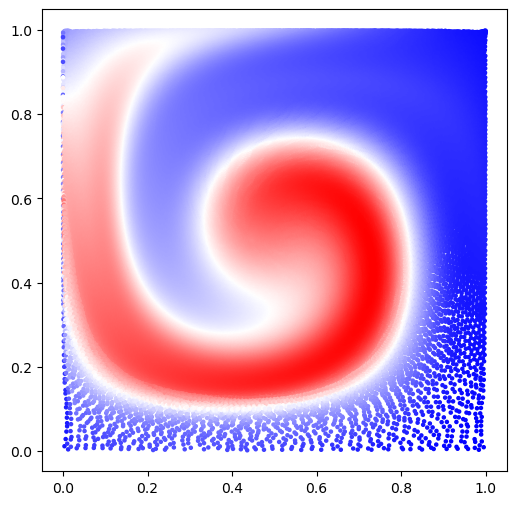

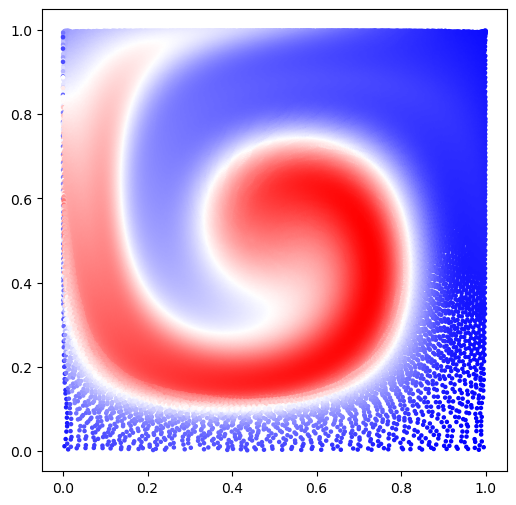

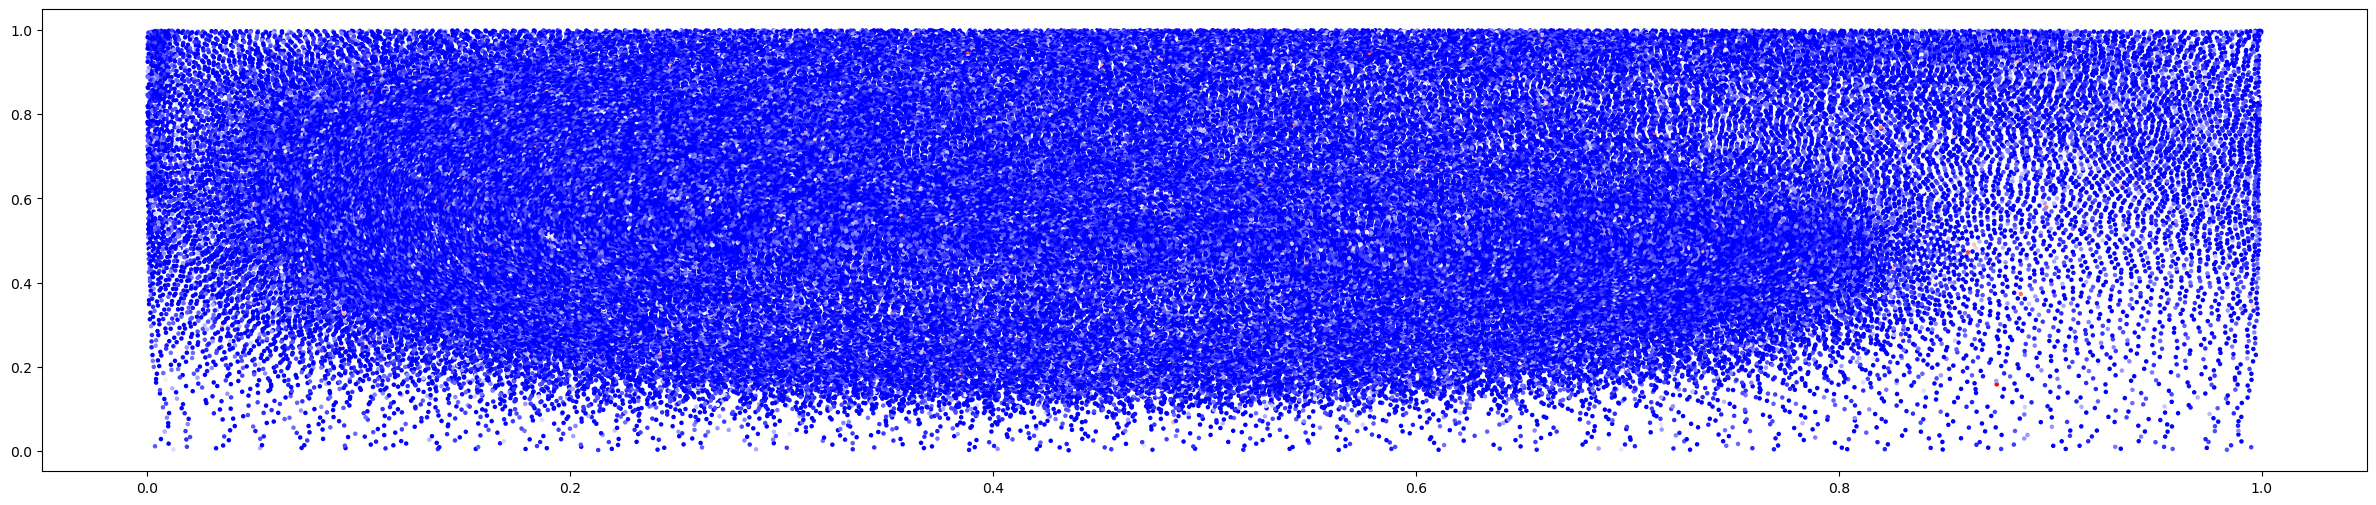

In [26]:
model.to("cpu")
xyfile = "/data/Sibo_22Mar2024/case_0/hessian_/xy_coords.npy"
marker_size = 5 #upped this to make points more visible
# load the file
xycoords_check = np.load(xyfile)

input = test_tensor_set[0, :, :]
input = input.unsqueeze(0)
real_input = test_set_real[0, :, :]

draw_pic(model, input, real_input, xycoords_check)